In [1]:
from tensorflow import keras
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

RESOLUTION_WIDTH = 224
RESOLUTION_HEIGHT = 224

2024-09-22 19:35:47.147650: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-22 19:35:47.250378: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11396611304108652286
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5788139520
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1682753984770224685
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


2024-09-22 19:35:57.135982: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-22 19:35:57.174046: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-22 19:35:57.174080: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-22 19:35:57.391047: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-22 19:35:57.391082: I external/local_xla/xla/stream_executor

Funciones para la imagenes Cargar y Mezclar

In [4]:
def cargar_imagenes(ruta, target_size=(RESOLUTION_WIDTH, RESOLUTION_HEIGHT)):
    X = []
    y = []
    for folder in os.listdir(ruta):
        for file in os.listdir(os.path.join(ruta, folder)):
                img = load_img(os.path.join(ruta, folder, file), target_size=target_size, color_mode='grayscale')
                img = img_to_array(img)
                X.append(img)
                y.append(0 if folder == 'no' else 1)
      
    return np.array(X), np.array(y)

def mezclar_dataset(X, y, semilla=0):
    indices = np.arange(X.shape[0])
    np.random.seed(semilla)
    np.random.shuffle(indices)
    return X[indices], y[indices]

In [5]:
X_train, y_train = cargar_imagenes('data_2/dataset/train')
X_val, y_val = cargar_imagenes('data_2/dataset/valid')
X_test, y_test = cargar_imagenes('data_2/dataset/test')

In [6]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(2800, 224, 224, 1) (200, 224, 224, 1) (6, 224, 224, 1)
(2800,) (200,) (6,)


In [7]:
X_train, y_train = mezclar_dataset(X_train, y_train)
X_val, y_val = mezclar_dataset(X_val, y_val)
X_test, y_test = mezclar_dataset(X_test, y_test)

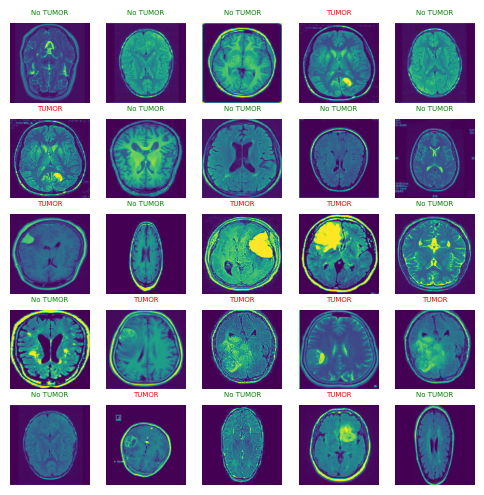

In [8]:
def mostrar_imagenes(X, y, n=5):
    plt.figure(figsize=(6, 6))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.imshow(X[i]/255)
        if y[i] == 0:
            plt.title('No TUMOR', color='green', fontsize=5)
        else:
            plt.title('TUMOR', color='red', fontsize=5)
        plt.axis('off')
    plt.show()

mostrar_imagenes(X_train, y_train)


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,             # Reescalar los valores de los pixeles
    rotation_range=20,          # Rango de grados para rotar la imagen
    width_shift_range=0.2,      # Rango de fracción para trasladar la imagen en horizontal
    height_shift_range=0.2,     # Rango de fracción para trasladar la imagen en vertical
    shear_range=0.2,            # Rango de ángulo para aplicar cizalladura
    zoom_range=0.2,             # Rango de zoom
    horizontal_flip=True,       # Voltea horizontalmente las imágenes
    fill_mode='nearest'         # Estrategia de relleno para los nuevos pixeles
)


datagen_test_val = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow(X_train, y_train, batch_size=32)

val_generator = datagen_test_val.flow(X_val, y_val, batch_size=32)
test_generator = datagen_test_val.flow(X_test, y_test, batch_size=32)

CNN

In [18]:
def crea_modelo_cnn(input_shape=(RESOLUTION_HEIGHT, RESOLUTION_WIDTH, 1)):

    model = keras.Sequential([
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=input_shape),
        keras.layers.BatchNormalization(),
        # keras.layers.Conv2D(64, (3, 3), padding = 'same', activation='relu'),
        # keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),
        
        
        keras.layers.Conv2D(128, (3, 3), padding = 'same', activation='relu'),
        keras.layers.BatchNormalization(),
        # keras.layers.Conv2D(128, (3, 3), padding = 'same', activation='relu'),
        # keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),

        
        keras.layers.Conv2D(128, (3, 3), padding = 'same', activation='relu'),
        keras.layers.BatchNormalization(),
        # keras.layers.Conv2D(128, (3, 3), padding = 'same', activation='relu'),
        # keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((3, 3), strides=2),
        
        keras.layers.Conv2D(256, (3, 3), padding = 'same', activation='relu'),
        keras.layers.BatchNormalization(),
        # keras.layers.Conv2D(256, (3, 3), padding = 'same', activation='relu'),
        # keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2), strides=2),
        
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.3),
        
        keras.layers.Dense(1, activation='sigmoid')   
    ])
    
    return model

model = crea_modelo_cnn()

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=7, factor=0.2, min_lr=1e-6)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 27, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 27, 27, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 27, 27, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,065,793 (23.14 MB)

 Trainable params: 6,064,641 (23.13 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [19]:
history = model.fit(train_generator, 
                    epochs=200,
                    validation_data=val_generator,
                    #batch_size = 75,
                    callbacks=[early_stopping, reduce_lr])

#evaluar el modelo
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Preción con test: {round(test_accuracy*100,2)} %')

Epoch 1/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 0.5373 - loss: 3.1056 - val_accuracy: 0.5000 - val_loss: 1.1702 - learning_rate: 0.0010
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.6161 - loss: 0.7339 - val_accuracy: 0.5000 - val_loss: 0.8948 - learning_rate: 0.0010
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.5708 - loss: 0.8081 - val_accuracy: 0.4900 - val_loss: 0.7045 - learning_rate: 0.0010
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.5648 - loss: 0.7479 - val_accuracy: 0.5100 - val_loss: 0.6473 - learning_rate: 0.0010
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.5775 - loss: 0.7065 - val_accuracy: 0.4900 - val_loss: 0.7003 - learning_rate: 0.0010
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.5514 - loss: 0.7739 - val_accuracy: 0.6000 - val_loss: 0.6578 - learning_rate: 0.0010
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.5686 - loss: 0.7231 

In [21]:
model.save('modelo_cnn.keras')

In [22]:
test_generator = val_generator

In [24]:
#evaluar el modelo
test_loss, test_acc = model.evaluate(test_generator)
print(f'Precisión con test: {round(test_acc*100,2)} %')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9793 - loss: 0.0767
Precisión con test: 96.5 %
